# **Problem 1**

In [ ]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.flatten_util import ravel_pytree

from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

This first script serves to import all of our special jax built-in functions as well as some useful tools to display our results.

In [ ]:
class SGD():
  def __init__(self, learning_rate = 1e-3):
    self.learning_rate = learning_rate

  def step(self, params, grad):
    params_flat, unravel = ravel_pytree(params)
    grad_flat, _ = ravel_pytree(grad)
    params_flat = params_flat - self.learning_rate*grad_flat
    return unravel(params_flat)

The above script is our Stochastic Gradient Descent Class.  This is essentially how our loss function changes over time.  The step function creates flattened parameters and a flattened gradient in order to use a vectorized method of learning or gradient descent.  We can then return the unflattened parameters after they've been modified.

In [ ]:
class LinearRegression():
  def __init__(self, X, y, rng_key):
    # Normalize data
    self.Xmean, self.Xstd = X.mean(0), X.std(0)
    self.Ymean, self.Ystd = y.mean(0), y.std(0)
    X = (X - self.Xmean)/self.Xstd
    y = (y - self.Ymean)/self.Ystd

    """
    First, we normalize our data so we can
    more efficiently characterize nd manipulate
    it
    """

    # Store the normalized trainind data
    self.X = X
    self.y = y
    self.dim = X.shape[1]

    """
    Next, we can initialize the structure of
    the data we store in our linear regression
    clss.
    """

    # Initialize the linear regression model
    self.init, self.apply = self.init_linear_regression(self.dim)
    self.params = self.init(rng_key)

    """
    This is our initialization of the linear
    regression model we will use.
    """

    # Create optimizer
    self.optimizer = SGD(learning_rate=1e-4)

    """
    In order to learn, we need to be able to perform
    SGD.
    """

    # Logger to monitor the loss function
    self.loss_log = []

  def init_linear_regression(self, dim):
    def _init(rng_key):
      w = random.normal(rng_key, (dim,))
      logsigma = -4.0 # Tip: use sigma = np.exp(logsigma) to constrain sigma to be positive!
      params = {'weights': w, 'noise_logvar': logsigma}
      return params
    def _apply(params, input):
      w = params['weights']
      out = np.dot(input, w)
      return out
    return _init, _apply

    """
    The above function initializes our linear
    model with a normal distribution of random
    numbers as the weights and a term for the 
    noisiness.  It also allows use to perform
    linear transformations on the data.
    """

  def per_example_loglikelihood(self, params, batch):
    X, y = batch
    y_pred = self.apply(params, X)
    sigma_sq = np.exp(params['noise_logvar'])
    loss = 0.5*np.log(2.0*np.pi*sigma_sq) + \
           0.5*(y - y_pred)**2/sigma_sq
    return loss

    """
    This function allows us to determine the loss
    via explicit formula for a given trial or epoch
    of data.
    """

  def loss(self, params, batch):
    # Implementation #1
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    loss = np.sum(vmap(pe_loss)(batch))
    # Implementation #2
    # loss = vmap(self.per_example_loglikelihood, in_axes = (None, 1))(params, batch)
    return loss
    
    """
    This is how we calculate the loss using the sum
    of a vector map which maps the loss on each
    parameter in a particular batch.
    """

  @partial(jit, static_argnums=(0,))
  def step(self, params, batch):
    g = grad(self.loss, 0)(params, batch)
    params = self.optimizer.step(params, g)
    return params

    """
    This uses the partial decorator.  The partial 
    decorator implies that we are calling jit and 
    calling the first function that jit compiles.
    This function uses the gradient of the loss 
    function at 0 in order to perform a learning 
    step in our SGD.
    """

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx, :], self.y[batch_idx]

    """
    This is a generator for the current batch of
    data we are examining in order to train our model
    """

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    params = self.params
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        params = self.step(params, batch)
      self.params = params
      loss_value = self.loss(params, batch)
      self.loss_log.append(loss_value)
      pbar.set_postfix({'Loss': loss_value})
    
    """
    This function does the training of our linear
    regression model over a specified number of
    epochs.  We look at our input data and create
    appropriately sized batches over which we can
    perform a single step of gradient descent.  This
    function does a large majority of the work needed
    to generate a linear/planar regression which
    matches a set of data.
    """

  def predict(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    pred_fn = lambda x: self.apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    y_pred = y_pred*self.Ystd + self.Ymean
    return y_pred

The above script serves to create a class which can be used to train a linear regression model.

In [ ]:
def f(x):
  x1, x2 = x[0], x[1]
  y = np.sqrt(3.0)*x1 + 2.0*x2
  return y

This is a model function to generate data with which we can create a linear regression model using the class we have previously created.

In [ ]:
rng_key = random.PRNGKey(0)

d = 2
n = 500
noise = 0.1

# Create training data
X = random.uniform(rng_key, (n, d))
y = vmap(f)(X)
y = y + noise*y.std(0)*random.normal(rng_key, y.shape)

# Create test data
nn = 50
xx = np.linspace(0, 1, nn)
yy = np.linspace(0, 1, nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

This script serves to generate the data points which represent a function we'd like to match with our linear model.

In [ ]:
model = LinearRegression(X, y, rng_key)

In [ ]:
model.train(num_epochs = 1000, batch_size = 64)

In [ ]:
opt_params = model.params
print(opt_params)
y_pred = model.predict(opt_params, X_star)

The previous scripts perform machine learning!  First, we generate our linear model.  Then we train the model and perform SGD.  We can then use our trained model to create a predicted model of the function we originally generated data points for.

In [ ]:
Yplot = griddata(X_star, y_pred, (XX, YY), method='cubic')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], y, 'r.', ms = 6, alpha = 0.5)
ax.plot_surface(XX, YY, Yplot, alpha = 0.8)
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')

plt.figure()
plt.plot(y_pred, y_star, 'r.', ms = 8, alpha = 0.5)
plt.plot(y_star, y_star, 'k--', lw = 3, alpha = 0.5)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')

plt.figure()
plt.plot(model.loss_log)
plt.yscale('log')
plt.xscale('log')

This is simply our plotting script.

# **Problem 2**

In [ ]:
import jax.numpy as np
from jax import random, vmap, grad, jit, jacfwd, jacrev
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas import read_csv
import numpy as onp
from sklearn.metrics import confusion_matrix

First we import useful libraries.

In [ ]:
from google.colab import files

uploaded1 = files.upload()
uploaded2 = files.upload()
uploaded3 = files.upload()

Saving datatest.txt to datatest (1).txt


Saving datatest2.txt to datatest2 (1).txt


Saving datatraining.txt to datatraining (1).txt


Now that we have imported the training data, test data, and validation data, we'd like to look at their contents.  First, we can use the tra




















  0%|          | 0/100 [00:00<?, ?it/s]

[ 1.18826636  0.45130584 -0.56193412  0.38375006  0.99494687]





















  0%|          | 0/100 [00:01<?, ?it/s, Loss=13.968978]


















  1%|          | 1/100 [00:01<01:55,  1.17s/it, Loss=13.968978]


















  1%|          | 1/100 [00:01<01:55,  1.17s/it, Loss=5.4192233]


















  2%|▏         | 2/100 [00:01<01:23,  1.17it/s, Loss=5.4192233]


















  2%|▏         | 2/100 [00:01<01:23,  1.17it/s, Loss=2.1490793]


















  3%|▎         | 3/100 [00:01<01:01,  1.58it/s, Loss=2.1490793]


















  3%|▎         | 3/100 [00:01<01:01,  1.58it/s, Loss=1.0745397]


















  4%|▍         | 4/100 [00:01<00:45,  2.09it/s, Loss=1.0745397]


















  4%|▍         | 4/100 [00:01<00:45,  2.09it/s, Loss=6.447238] 


















  5%|▌         | 5/100 [00:01<00:36,  2.62it/s, Loss=6.447238]


















  5%|▌         | 5/100 [00:01<00:36,  2.62it/s, Loss=4.2981586]


















  6%|▌         | 6/100 [00:01<00:29,  3.23it/s, Loss=4.2981586]


















  6%|▌

[-6.1111981e+02 -3.9031824e+02 -2.0241857e-01 -9.8047256e-02
  2.6372330e+06]
Classification accuracy test set: 0.635%
Classification accuracy validation set: 0.790%


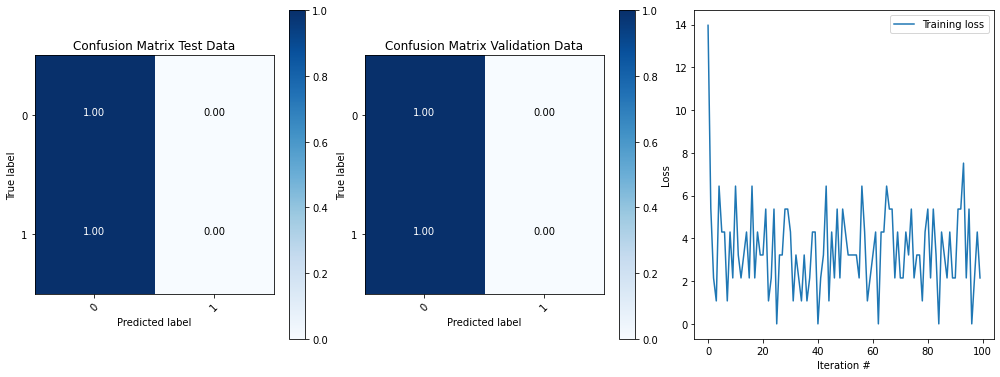

In [ ]:
# Create training data
data_train = read_csv('datatraining.txt', header=0, index_col=1, parse_dates=True, squeeze=True)
data_test1 = read_csv('datatest.txt', header=0, index_col=1, parse_dates=True, squeeze=True)
data_validation = read_csv('datatest2.txt', header=0, index_col=1, parse_dates=True, squeeze=True)    

data_train = data_train.to_numpy()

N = data_train.shape[0]
features = data_train[:,1:-1]
labels = data_train[:,-1]
# Training data 
X_train = features.astype('float32') 
# X_train = onp.ones((features.shape[0], features.shape[1]))
# X_train = random.normal(rng_key, (features.shape[0], features.shape[1]))
y_train = labels[:,None].astype('int32')

# Test data
features_test1 = data_test1.values[:,1:-1]
labels_test1 = data_test1.values[:,-1]

X_test1 = features_test1.astype('float32') 
y_test1 = labels_test1[:,None].astype('int32')

# Validation data
features_validation = data_validation.values[:,1:-1]
labels_validation = data_validation.values[:,-1]

X_val = features_validation.astype('float32')
y_val = labels_validation[:,None].astype('int32')

# Create test data

rng_key = random.PRNGKey(0)

model = LogisticRegression(X_train, y_train, rng_key)
model.train(num_epochs = 100, batch_size = 64) # start with ~100 epocss 
w = model.params
print(w["weights"])
# Prediction
test_labels = model.predict(w, X_test1).astype('int32')

ACC1 = model.accuracy(y_test1[:,-1], test_labels[:,None])
print('Classification accuracy test set: %.3f%%' % (ACC1.mean(0)))
plt.figure(1, figsize=(14,5))

plt.subplot(1,3,1)
plot_confusion_matrix(model.M, classes=np.arange(2), normalize=True, title="Confusion Matrix Test Data")

test_labels = model.predict(w, X_val)

ACC2 = model.accuracy(y_val[:,-1], test_labels)
print('Classification accuracy validation set: %.3f%%' % (ACC2.mean(0)))
plt.subplot(1,3,2)
plot_confusion_matrix(model.M, classes=np.arange(2), normalize=True,title="Confusion Matrix Validation Data")


# Plotting
plt.subplot(1,3,3)
plt.plot(model.loss_log, label = 'Training loss')

plt.legend()
plt.xlabel('Iteration #')
plt.ylabel('Loss')
plt.show()


In [ ]:
class IRLS():

  def step(self, params, grad, hess):

    params_flat, unravel = ravel_pytree(params)
    grad_flat, _ = ravel_pytree(grad)
    
    params_flat = params_flat - np.matmul(hess, grad_flat)
    return unravel(params_flat)

In [ ]:
class LogisticRegression():
  def __init__(self, X, y, rng_key):

    self.X = X
    self.y = y
    self.dim = X.shape[1]
    
    self.jitter = 1e-8

    # Initialize the logistic regression model
    self.init, self.apply = self.init_logistic_regression(self.dim)
    self.params = self.init(rng_key)
    
    print(self.params["weights"])
    # Create optimizer for an IRLS model
    self.optimizer = IRLS()

    # Logger to monitor the loss function
    self.loss_log = []

  def init_logistic_regression(self, dim):
    def _init(rng_key):
      w = onp.random.randn(dim,)
      params = {'weights': w}
      return params
    def _apply(params, input):
      out = np.dot(input,params['weights'])
      return out
    return _init, _apply

  """
  You will need to define the sigmoid function.

  resolved.
  """
  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))
    def _apply(params, input):
      w = params['weights'] 
      out = self.sigmoid(np.dot(input, w))
      return out 
    return _init, _apply

  """
  New loss function for logistic regression.
  """
  def per_example_loglikelihood(self, params, batch):
    X, y = batch
    X = self.apply(params,X)
    loss_value =  y[0]*np.log(self.sigmoid(X) + 1e-7) + (1. - y[0])*np.log(1. - self.sigmoid(X) + 1e-7)
    return loss_value
  """
  Now we find the loss function for the whole batch
  """    
  def loss(self, params, batch):
    # Implementation #1
    X, y = batch
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    loss = -np.mean(vmap(pe_loss)(batch))
    return loss

  @partial(jit, static_argnums=(0,))
  def step(self, params, batch):
    X, y = batch

    app = lambda x: self.apply(params, x)
    a = vmap(app)(X) 
    a_i = a * (1-a) + self.jitter
    A = np.diag(a_i) 
    w = params['weights']
    a1 = np.linalg.inv(np.matmul(np.matmul(X.T , A), X))
    a2 = np.matmul(X.T, A)
    a3 = np.matmul(X, w) - np.matmul(np.linalg.inv(A), (a_i - y.flatten()))
    w = np.matmul(np.matmul(a1, a2), a3)
    params['weights'] = w
    return params

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx, :], self.y[batch_idx]

  """
  What you need to do here is you need to understand how the training function 
  has to change in order to implement IRLS. 
  The optimizer asked in the homework is not SGD, but IRLS. So you will have to define a new function,
  class or harcode the update rule in the train function.

  resolved in our step function.
  """
  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    params = self.params
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        params = self.step(params, batch)
      self.params = params
      loss_value = self.loss(params, batch)
      self.loss_log.append(np.abs(loss_value))
      pbar.set_postfix({'Loss': loss_value})

  def predict(self, params, X_star):
    pred_fn = lambda x: self.apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    return self.sigmoid(y_pred)

  def accuracy(self, y_test, test_labels):
    # Compute confusion matrix
    self.M = confusion_matrix(y_test, test_labels)
    
    # False positives, False negatives, True positives, True negatives
    FP = self.M.sum(axis=0) - np.diag(self.M)  
    FN = self.M.sum(axis=1) - np.diag(self.M)
    TP = np.diag(self.M)
    TN = self.M.sum() - (FP + FN + TP)
            
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return ACC

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# **Problem 3**

In [148]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.flatten_util import ravel_pytree
from jax.ops import index, index_add, index_update
import numpy as onp

from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from jax.nn import sigmoid

In [149]:
class SGD():
  def __init__(self, learning_rate = 1e-3):
    self.learning_rate = learning_rate

  def step(self, params, grad):
    params_flat, unravel = ravel_pytree(params)
    grad_flat, _ = ravel_pytree(grad)
    params_flat = params_flat - self.learning_rate*grad_flat
    return unravel(params_flat)

In [150]:
class LinearRegression():
  def __init__(self, X, y, rng_key):
    # Normalize data
    self.Xmean, self.Xstd = X.mean(0), X.std(0)
    self.Ymean, self.Ystd = y.mean(0), y.std(0)
    X = (X - self.Xmean)/self.Xstd
    y = (y - self.Ymean)/self.Ystd

    # Store the normalized trainind data
    self.X = X
    self.y = y
    self.dim = X.shape[1]

    # Initialize the linear regression model
    self.init, self.apply = self.init_linear_regression(self.dim)
    self.params = self.init()
    print(self.params)
    # Create optimizer
    self.optimizer = SGD(learning_rate=1e-4)

    # Logger to monitor the loss function
    self.loss_log = []

  """
  Remember now you not only have w, but also 2 presicion parameters alpha and beta.
  You will need to find a way to add them in this function and then you will need
  to think on how to take gradients of the loss function based on these parameters.

  Do you need to change the initialization? How?

  We need to change the initialization of our linear regression code.  First,
  in order to meet problem specs, we need to incorporate an alpha and a beta.
  Then we need to intitialize them to the values given in the problem.  Similarly
  we must initialize our regression weights slightly differently.

  """
  def init_linear_regression(self, dim):
    def _init():
      # we first set the initial var to be 0.2
      logsigma = -1.609 # Tip: use sigma = np.exp(logsigma) to constrain sigma to be positive!
      alpha = 5.0
      beta = 0.1
      w = npr.normal(0, np.sqrt(beta), (dim,))
      params = {'weights': w, 'noise_logvar': logsigma, 'alpha': alpha, 'beta': beta }
      return params
    def _apply(params, input):
      w = params['weights']
      out = sigmoid(np.dot(input, w))
      return out
    return _init, _apply

  """
  How will this function change based on the relation given in the problem statement?
  You will need to add the precision parameters.

  This function will change to implement the log of the likelihood given in the 
  problem statement.
  """
  def per_example_loglikelihood(self, params, batch):
    X, y = batch
    y_pred = self.apply(params, X)
    weights = params['weights']
    sigma_sq = np.exp(params['noise_logvar'])
    alpha = params['alpha']
    beta = params['beta']
    a1 = (len(batch) / 2)*(np.log(2*np.pi / alpha) + np.log(2*np.pi / beta))
    term = (y.flatten() - np.matmul(X, weights))
    a2 = (alpha / 2)*np.matmul(term, term.T)
    a3 = (beta / 2)*np.matmul(weights.T, weights)
    loss = a1 + a2 + a3
    return loss

  def loss(self, params, batch):
    # Implementation #1
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    loss = np.sum(vmap(pe_loss)(batch))
    # Implementation #2
    # loss = vmap(self.per_example_loglikelihood, in_axes = (None, 1))(params, batch)
    return loss

  """
  Now you have more parameters, do you need to change this function? Think about it.

  For the main step, we do not need to change this function, however in our ADAM
  implementation, we must change this function.

  """
  @partial(jit, static_argnums=(0,))
  def step(self, params, batch):
    g = grad(self.loss, 0)(params, batch)
    print(g)
    params = self.optimizer.step(params, g)
    return params

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx, :], self.y[batch_idx]

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    params = self.params
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        params = self.step(params, batch)
      self.params = params
      loss_value = self.loss(params, batch)
      self.loss_log.append(np.abs(loss_value))
      pbar.set_postfix({'Loss': loss_value})

  def predict(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    pred_fn = lambda x: self.apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    y_pred = y_pred*self.Ystd + self.Ymean
    return y_pred

In [ ]:
!pip install pydoe

  Created wheel for pydoe: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=bc57f3b82386bc391d5712eff86b8e844881e6ee3f75fc7030b3da914aaa0335
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pydoe


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  



















  0%|          | 0/100 [00:00<?, ?it/s]

(2500, 2)
{'weights': array([-0.57345282, -0.21274388, -0.29087079,  0.01858773,  0.03970096,
        0.32664942,  0.26668516,  0.49778017, -0.01701926, -0.32109955,
        0.12004678,  0.41003612,  0.27105682, -0.11033333, -0.51945223,
       -0.29054141]), 'noise_logvar': -1.609, 'alpha': 5.0, 'beta': 0.1}
{'alpha': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, 'beta': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, 'noise_logvar': array(0., dtype=float32), 'weights': Traced<ShapedArray(float32[16])>with<DynamicJaxprTrace(level=0/1)>}
{'alpha': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, 'beta': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, 'noise_logvar': array(0., dtype=float32), 'weights': Traced<ShapedArray(float32[16])>with<DynamicJaxprTrace(level=0/1)>}
{'alpha': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, 'beta': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)




















  0%|          | 0/100 [00:00<?, ?it/s, Loss=nan]


















  1%|          | 1/100 [00:00<00:55,  1.80it/s, Loss=nan]


















  1%|          | 1/100 [00:00<00:55,  1.80it/s, Loss=nan]


















  1%|          | 1/100 [00:00<00:55,  1.80it/s, Loss=nan]


















  1%|          | 1/100 [00:00<00:55,  1.80it/s, Loss=nan]


















  4%|▍         | 4/100 [00:00<00:38,  2.48it/s, Loss=nan]


















  4%|▍         | 4/100 [00:00<00:38,  2.48it/s, Loss=nan]


















  4%|▍         | 4/100 [00:00<00:38,  2.48it/s, Loss=nan]


















  4%|▍         | 4/100 [00:00<00:38,  2.48it/s, Loss=nan]


















  7%|▋         | 7/100 [00:00<00:27,  3.40it/s, Loss=nan]


















  7%|▋         | 7/100 [00:00<00:27,  3.40it/s, Loss=nan]


















  7%|▋         | 7/100 [00:00<00:27,  3.40it/s, Loss=nan]


















  7%|▋         | 7/100 [00:00<00:27,  3.40it/s, Loss=nan]


















 

{'alpha': DeviceArray(nan, dtype=float32), 'beta': DeviceArray(nan, dtype=float32), 'noise_logvar': DeviceArray(-1.609, dtype=float32), 'weights': DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan], dtype=float32)}


IndexError: ignored

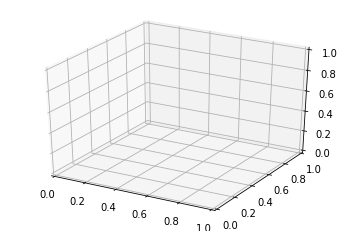

In [151]:
"""
Now your function will be different. Remember you will have to use sin's and you
will need to be careful on the vectorization. First calculate f(x) and then add
the noise.
"""
def f(x):
  a_1 = np.sin(2.0*np.pi*x)
  a_2 = np.sin(3.0*np.pi*x)
  a_3 = np.sin(4.0*np.pi*x)
  y = a_1 + a_2 + a_3
  
  return y


rng_key = random.PRNGKey(0)

d = 1
n = 500
noise = 0.1

# Create training data
X1 = random.uniform(rng_key, (n, d))
X = onp.asarray(X1)
y = vmap(f)(X)
y = y + noise*y.std(0)*random.normal(rng_key, y.shape)

# Create test data
nn = 50
xx = np.linspace(0, 1, nn)
yy = np.linspace(0, 1, nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

print(y_star.shape)
"""
Remember you will need to provide the Fourier features here. How will you be able
to do that? You should use Phi not X!!

I understand what is going on here, but I cant seem to figure out how to get the
basis function to be applied to a JAX array.  I tried sidestepping the immutability
of these arrays by using a standard numpy array, but I think I created more problems
than I solved.  
"""
phi_x_mat = bases.fourier_basis(X)
model = LinearRegression(phi_x_mat, y, rng_key)
model.train(num_epochs = 100, batch_size = 64)
opt_params = model.params
print(opt_params)
#y_pred = model.predict(opt_params, X_star)

Yplot = griddata(X_star, y_pred, (XX, YY), method='cubic')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], y, 'r.', ms = 6, alpha = 0.5)
ax.plot_surface(XX, YY, Yplot, alpha = 0.8)
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.figure()
plt.plot(y_pred, y_star, 'r.', ms = 8, alpha = 0.5)
plt.plot(y_star, y_star, 'k--', lw = 3, alpha = 0.5)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')

plt.figure()
plt.plot(model.loss_log)
plt.yscale('log')
plt.xscale('log')

  0%|          | 0/100 [24:00<?, ?it/s]


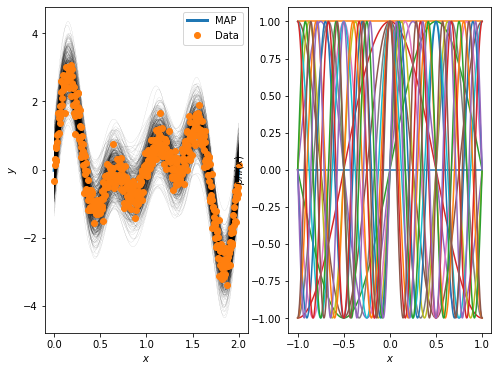

In [144]:
class BayesianLinearRegression:
  """
    Linear regression model: y = (w.T)*x + \epsilon
    w ~ N(0,beta^(-1)I)
    P(y|x,w) ~ N(y|(w.T)*x,alpha^(-1)I)
  """
  def __init__(self, X, y, alpha = 1.0, beta = 1.0):
      
      self.X = X
      self.y = y
      
      self.alpha = alpha
      self.beta = beta
      
      self.jitter = 1e-6
      
  def fit_MAP(self): 
      Lambda = np.matmul(self.X.T,self.X) + \
               (self.beta/self.alpha)*np.eye(self.X.shape[1])
      Lambda_inv = np.linalg.inv(Lambda)
      xTy = np.matmul(self.X.T, self.y)
      mu = np.matmul(Lambda_inv, xTy)
      
      self.w_MAP = mu
      self.Lambda_inv = Lambda_inv
      
      return mu, Lambda_inv
      
  def predictive_distribution(self, X_star):
      mean_star = np.matmul(X_star, self.w_MAP)
      var_star = 1.0/self.alpha + \
                 np.matmul(X_star, np.matmul(self.Lambda_inv, X_star.T))
      return mean_star, var_star

import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from scipy.special import legendre

class bases:
    def __init__(self, order):  
        self.order = order
        
    """
    In order to use this function, we must transform the indices of a JAX
    array such that we do not make any in place modifications to the array
    """
    def fourier_basis(self,x):
        points = onp.ones((x.shape[0],2*self.order))
        for i in range(0,self.order):
            points[:,2*i] = np.sin(i*np.pi*x).T
            points[:,2*i+1] = np.cos(i*np.pi*x).T
        return points

    
if __name__ == "__main__": 
    
    # N is the number of training points.
    N = 500
    noise_var = 0.3
    alpha = 5.
    beta = 0.1
    order = 8
    
    # Create random input and output data
    lb = 0.
    ub = 2.
    X = lb + (ub-lb)*lhs(1, N)
    y = f(X) + noise_var*np.random.randn(N,1)
    
    bases = bases(order)
    basis = bases.fourier_basis
    
    phi_x_m = basis(X)
    # Define model
    m = BayesianLinearRegression(phi_x_m, y, alpha, beta)
    
    # Fit MLE and MAP estimates for w
    w_MAP, Lambda_inv = m.fit_MAP()
    # Predict at a set of test points
    X_star = np.linspace(lb,ub,N)[:,None]
    phi_star_m = basis(X_star)
    
    y_pred_MAP = np.matmul(phi_star_m, w_MAP)
    
    # Draw sampes from the predictive posterior
    num_samples = N
    mean_star, var_star = m.predictive_distribution(phi_star_m)
    samples = np.random.multivariate_normal(mean_star.flatten(), var_star, num_samples)
    
    # Plot
    plt.figure(1, figsize=(8,6))
    plt.subplot(1,2,1)
    plt.plot(X_star, y_pred_MAP, linewidth=3.0, label = 'MAP')
    for i in range(0, num_samples):
        plt.plot(X_star, samples[i,:], 'k', linewidth=0.05)
    plt.plot(X,y,'o', label = 'Data')
    plt.legend()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.axis('tight')


    # Plot distribution of w
    plt.subplot(1,2,2)
    x_axis = np.linspace(-1., 1., N)[:,None]
    phi_axis_m = basis(x_axis)

    plt.plot(x_axis,phi_axis_m) 
    plt.xlabel('$x$')
    plt.ylabel('$phi(x)$')
    plt.axis('tight')